Note:

Dropped  the timestamps, we only use indexes.
This also removed the large holes in the dataset, and data is not filled in anymore.

I have seen a lot of steps without lots of movement of the buy price. I then resampled the data to 1 hour intervals by using the median of every 12 steps.

**interesting enough, this has helped a lot of bringing in movement in the forecast**

why this is helping im not sure, maybe it trains the model to assume more movement than there really is?

In [11]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [12]:
from darts.models import LightGBMModel
import pandas as pd
import numpy as np
import matplotlib
import tempfile
from darts.models import LightGBMModel
from darts.metrics import mape, rmse, mae
import mlflow
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [15]:
# Download source data from s3
from ml.common.folder_s3_sync import download_folder_from_s3
import os


datapath = os.path.join(os.getenv('DATA_PATH'), 'train_lightgbm', 'gw2')


download_folder_from_s3(s3_folder_prefix='datasources/gw2/raw/1763399444', local_folder=datapath)

df = pd.read_csv(f'{datapath}/Copper Ore.csv', delimiter=";")


Source: ost-s3/datasources/gw2/raw/1763399444
Target: /home/lukas/Documents/Github/casml4se-stonkswagen/data/train_lightgbm/gw2

Found 60 files to download

✓ +1 Agony Infusion.csv
✓ Auric Sliver.csv
✓ Bag of Coffee Beans.csv
✓ Bag of Sugar.csv
✓ Black Lion Chest.csv
✓ Bowl of Candy Corn Custard.csv
✓ Choya Spine.csv
✓ Congealed Putrescence.csv
✓ Copper Ore.csv
✓ Cup of Spiced Apple Cider.csv
✓ Elder Wood Log.csv
✓ Eye of Kormir.csv
✓ Flawless Snowflake.csv
✓ Fried Golden Dumpling.csv
✓ Glass of Buttered Spirits.csv
✓ Glob of Ectoplasm.csv
✓ Gold Ingot.csv
✓ Gold Ore.csv
✓ Gossamer Scrap.csv
✓ Green Wood Log.csv
✓ Handful of Red Lentils.csv
✓ Iron Ore.csv
✓ Jug of Water.csv
✓ Jute Scrap.csv
✓ Large Bone.csv
✓ Large Claw.csv
✓ Large Fang.csv
✓ Large Scale.csv
✓ Ley-Infused Sand.csv
✓ Lucent Mote.csv
✓ Lucky Draketail.csv
✓ Lucky Prismatic Rocket.csv
✓ Lump of Coal.csv
✓ Mithril Ore.csv
✓ Mystic Coin.csv
✓ Orichalcum Ore.csv
✓ Piece of Candy Corn.csv
✓ Piece of Common Unidentified Gear.c

In [ ]:
from darts import TimeSeries

def get_series_resampled(path, resample_interval):
    df = pd.read_csv(path, delimiter=";")
    value_cols = ["buy_unit_price"]

    tsdf = df[value_cols].copy()

    # Reset index to use integer index instead of timestamp
    tsdf = tsdf.reset_index(drop=True)

    if resample_interval > 1:
        tsdf = tsdf.groupby(tsdf.index // resample_interval).median()


    # Create TimeSeries with integer index
    series = TimeSeries.from_dataframe(tsdf, value_cols=value_cols)


    return series

sample = get_series_resampled(f"{datapath}Copper Ore.csv", resample_interval=12)

In [ ]:
def train_val_split(series, split_percentage):
    train, val = series.split_after(split_percentage)
    return train, val

samples = get_series_resampled(f"{datapath}Copper Ore.csv", resample_interval=12)
samplet, samplev = train_val_split(samples, split_percentage=0.8)
samplet.plot(label="training")
samplev.plot(label="validation")

In [ ]:
def train_lightgbm_model(item="Jute Scrap.csv",run_name="lightgbm", resample_interval=12, split_percentage=0.8,
                         lags=256, output_chunk_length=256, mlflow_nested_run = False):
    """
    Train a LightGBM model for time series forecasting.

    Parameters:
    -----------
    item : str
        Name of the CSV file to load (e.g., "Jute Scrap.csv")
    resample_interval : int
        Interval for resampling the data
    split_percentage : float
        Percentage for train/validation split (0.0 to 1.0)
    lags : int
        Number of lags to use in the model
    output_chunk_length : int
        Output chunk length for the model

    Returns:
    --------
    tuple
        (model, train, val, pred, metrics_dict)
    """


    with mlflow.start_run(run_name=run_name, nested=mlflow_nested_run):
        # Load and prepare data
        series_sampled = get_series_resampled(f"{datapath}{item}", resample_interval=resample_interval)
        train, val = train_val_split(series_sampled, split_percentage)
        prediction_horizon = len(val)

        # Model parameters
        model_params = {
            "lags": lags,
            "lags_past_covariates": None,
            "lags_future_covariates": None,
            "output_chunk_length": output_chunk_length,
            "force_row_wise": True,
            "device": "gpu",
        }

        # Log parameters
        mlflow.log_params({
            "resample_interval": resample_interval,
            "train_test_split": split_percentage,
            "prediction_horizon": prediction_horizon,
            **model_params
        })

        # Train model
        model = LightGBMModel(**model_params)
        model.fit(train)

        # Make predictions
        pred = model.predict(n=prediction_horizon)

        # Calculate metrics
        val_short = val[:prediction_horizon]
        mape_score = mape(val_short, pred)
        rmse_score = rmse(val_short, pred)
        mae_score = mae(val_short, pred)

        # Log metrics
        metrics_dict = {
            "mape": mape_score,
            "rmse": rmse_score,
            "mae": mae_score
        }
        mlflow.log_metrics(metrics_dict)

        # Save and log artifacts
        with tempfile.TemporaryDirectory() as tmpdir:
            train.to_csv(f"{tmpdir}/train.csv")
            val.to_csv(f"{tmpdir}/val.csv")
            pred.to_csv(f"{tmpdir}/pred.csv")
            mlflow.log_artifacts(tmpdir, artifact_path="series")

            # Create and log the prediction plot
            fig, ax = plt.subplots(figsize=(12, 6))
            train[-200:].plot(label="training", ax=ax)
            val_short.plot(label="validation", ax=ax)
            pred.plot(label="prediction", ax=ax)
            ax.legend()
            ax.set_title(f"Model Predictions vs Actual Values - {item}")

            # Log the figure directly without saving to disk
            mlflow.log_figure(fig, "prediction_plot.png")
            plt.close(fig)

        # Log model
        mlflow.sklearn.log_model(model.model, "lightgbm_model")

        # Log additional info
        mlflow.set_tags({
            "dataset": item.removesuffix(".csv"),
            "model_type": "LightGBM",
            "framework": "Darts"
        })

        # Print results
        print(f"MAPE: {mape_score:.2f}%")
        print(f"RMSE: {rmse_score:.2f}")
        print(f"MAE: {mae_score:.2f}")

        # Plot results
        train[-200:].plot(label="training")
        val_short.plot(label="validation")
        pred.plot(label="prediction")

        return model, train, val, pred, metrics_dict

In [ ]:
from itertools import product
import mlflow

def grid_search_lightgbm(items, param_grid, experiment_name="lightgbm_gridsearch"):
    """
    Perform grid search over LightGBM parameters for multiple items.

    Parameters:
    -----------
    items : list of str
        List of CSV file names to test
    param_grid : dict
        Dictionary with parameter names as keys and lists of values to test
        Example: {
            'resample_interval': [6, 12, 24],
            'lags': [128, 256, 512],
            'output_chunk_length': [128, 256],
            'split_percentage': [0.7, 0.8]
        }
    experiment_name : str
        MLflow experiment name

    Returns:
    --------
    pd.DataFrame
        Results of all combinations with metrics
    """
    mlflow.set_experiment(experiment_name)

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = []
    total_runs = len(combinations) * len(items)
    current_run = 0

    with mlflow.start_run(run_name="grid_search_parent"):
        for item in items:
            for combo in combinations:
                current_run += 1
                params = dict(zip(param_names, combo))

                run_name = f"{item.removesuffix('.csv')}_" + "_".join([f"{k}={v}" for k, v in params.items()])

                print(f"\n[{current_run}/{total_runs}] Training: {run_name}")

                try:
                    model, train, val, pred, metrics = train_lightgbm_model(
                        item=item,
                        run_name=run_name,
                        mlflow_nested_run=True,
                        **params
                    )

                    result = {
                        'item': item,
                        **params,
                        **metrics,
                        'status': 'success'
                    }
                    print(f"✓ Success - MAPE: {metrics['mape']:.2f}%, RMSE: {metrics['rmse']:.2f}")

                except Exception as e:
                    result = {
                        'item': item,
                        **params,
                        'mape': None,
                        'rmse': None,
                        'mae': None,
                        'status': 'failed',
                        'error': str(e)
                    }
                    print(f"✗ Failed - Error: {e}")

                results.append(result)

        # Create summary DataFrame
        results_df = pd.DataFrame(results)

        # Save results as artifact
        with tempfile.TemporaryDirectory() as tmpdir:
            results_path = f"{tmpdir}/grid_search_results.csv"
            results_df.to_csv(results_path, index=False)
            mlflow.log_artifact(results_path)

            # Create summary statistics
            if results_df['mape'].notna().any():
                summary = results_df[results_df['status'] == 'success'].groupby('item').agg({
                    'mape': ['min', 'mean', 'max'],
                    'rmse': ['min', 'mean', 'max'],
                    'mae': ['min', 'mean', 'max']
                })
                summary_path = f"{tmpdir}/summary_by_item.csv"
                summary.to_csv(summary_path)
                mlflow.log_artifact(summary_path)

                print("\n" + "="*80)
                print("SUMMARY BY ITEM:")
                print("="*80)
                print(summary)

    return results_df

In [ ]:
items = [
    "Copper Ore.csv",
    "Iron Ore.csv",
    "Gold Ore.csv",
    "Gold Ingot.csv",
    "Silver Ore.csv",
    "Mithril Ore.csv",
    "Bag of Sugar.csv"
]

# Define parameter grid
param_grid = {
    'resample_interval': [1,6,12,24],
    'lags': [32,64,128,256],
    'output_chunk_length': [32,128,256]
}

# Run grid search
results_df = grid_search_lightgbm(items, param_grid)

# Display results
print("\n" + "="*80)
print("ALL RESULTS:")
print("="*80)
print(results_df)

Found 337 runs

TOP 10 RUNS BY MAPE:
                                                           run_name  param_resample_interval param_train_test_split param_prediction_horizon  param_lags param_lags_past_covariates param_lags_future_covariates  param_output_chunk_length param_force_row_wise param_device  metric_mape  metric_rmse  metric_mae tag_dataset
0     Copper Ore_resample_interval=1_lags=64_output_chunk_length=32                      1.0                    0.8                     4694        64.0                       None                         None                       32.0                 True          gpu     1.606542     1.332750    0.664618  Copper Ore
1    Copper Ore_resample_interval=1_lags=128_output_chunk_length=32                      1.0                    0.8                     4694       128.0                       None                         None                       32.0                 True          gpu     1.609537     1.335207    0.665874  Copper Ore
2  

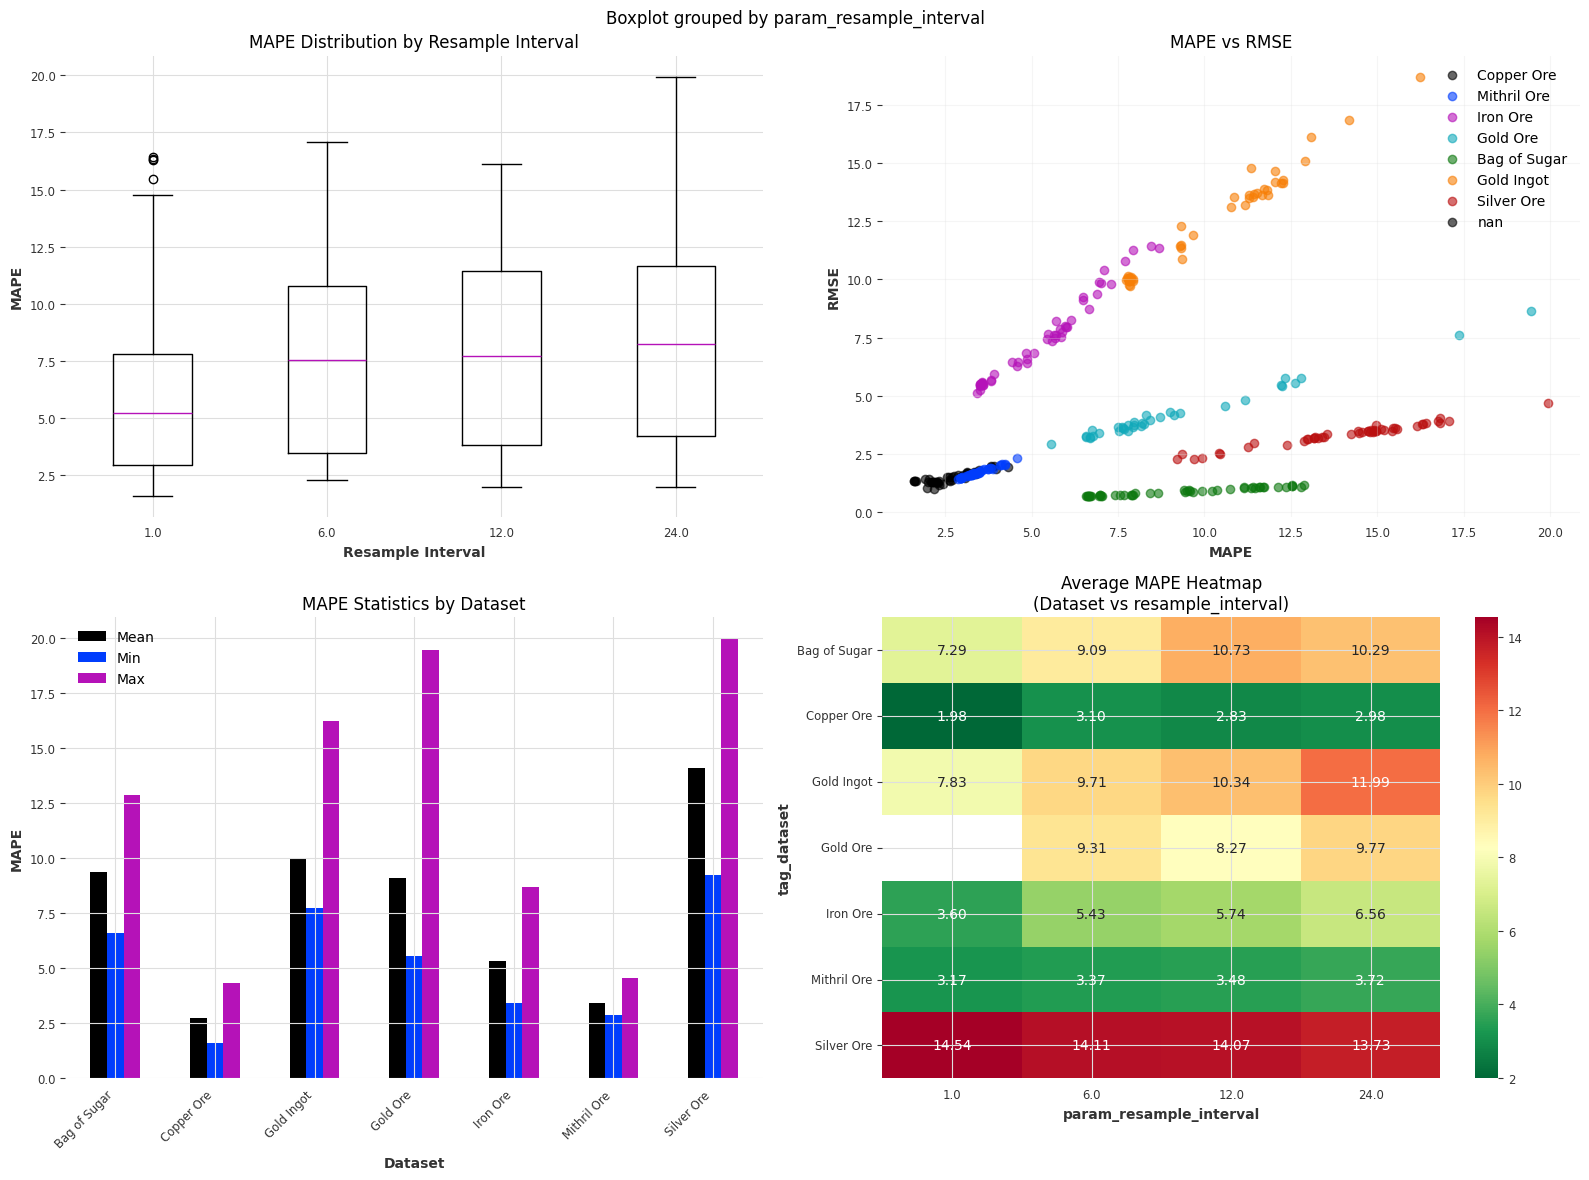


SUMMARY STATISTICS:

Overall MAPE: 7.67 ± 4.27
Best MAPE: 1.61
Worst MAPE: 19.95

By Dataset:
             metric_mape                      metric_rmse            \
                    mean       min        max        mean       min   
tag_dataset                                                           
Bag of Sugar    9.351780  6.583297  12.886250    0.884703  0.700061   
Copper Ore      2.723799  1.606542   4.308554    1.489504  0.997675   
Gold Ingot      9.966496  7.744393  16.246455   12.181380  9.730568   
Gold Ore        9.117610  5.570488  19.447102    4.230549  2.941072   
Iron Ore        5.331548  3.434626   8.673385    7.464272  5.137522   
Mithril Ore     3.435874  2.885189   4.576077    1.698284  1.435123   
Silver Ore     14.113014  9.214758  19.945499    3.343536  2.271947   

                        metric_mae                       
                    max       mean       min        max  
tag_dataset                                              
Bag of Sugar   1.164

In [10]:
# Compare Grid Search Results from MLflow
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def get_gridsearch_results(experiment_name="lightgbm_gridsearch"):
    """
    Pull all grid search runs from MLflow and create a comparison DataFrame.

    Parameters:
    -----------
    experiment_name : str
        Name of the MLflow experiment

    Returns:
    --------
    pd.DataFrame
        DataFrame with all runs and their metrics/parameters
    """
    client = MlflowClient()

    # Get experiment
    experiment = client.get_experiment_by_name(experiment_name)
    if experiment is None:
        print(f"Experiment '{experiment_name}' not found!")
        return None

    # Get all runs from the experiment
    runs = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string="",
        order_by=["metrics.mape ASC"]
    )

    # Extract data from runs
    runs_data = []
    for run in runs:
        run_data = {
            'run_id': run.info.run_id,
            'run_name': run.info.run_name,
            'status': run.info.status,
            'start_time': pd.to_datetime(run.info.start_time, unit='ms'),
        }

        # Add parameters
        run_data.update({f'param_{k}': v for k, v in run.data.params.items()})

        # Add metrics
        run_data.update({f'metric_{k}': v for k, v in run.data.metrics.items()})

        # Add tags
        run_data.update({f'tag_{k}': v for k, v in run.data.tags.items()})

        runs_data.append(run_data)

    df = pd.DataFrame(runs_data)

    # Clean up column names and convert types
    if 'param_resample_interval' in df.columns:
        df['param_resample_interval'] = pd.to_numeric(df['param_resample_interval'], errors='coerce')
    if 'param_lags' in df.columns:
        df['param_lags'] = pd.to_numeric(df['param_lags'], errors='coerce')
    if 'param_output_chunk_length' in df.columns:
        df['param_output_chunk_length'] = pd.to_numeric(df['param_output_chunk_length'], errors='coerce')

    return df


# Get results
results_df = get_gridsearch_results()

if results_df is not None and len(results_df) > 0:
    print(f"Found {len(results_df)} runs")
    print("\n" + "=" * 80)
    print("TOP 10 RUNS BY MAPE:")
    print("=" * 80)

    # Display top runs
    display_cols = [col for col in results_df.columns if
                    col.startswith(('run_name', 'metric_', 'param_', 'tag_dataset'))]
    top_runs = results_df[display_cols].head(10)
    print(top_runs.to_string())

    # Filter out parent runs (they don't have actual predictions)
    child_runs = results_df[~results_df['run_name'].str.contains('parent', case=False, na=False)]

    if len(child_runs) > 0:
        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. MAPE distribution by resample_interval
        if 'param_resample_interval' in child_runs.columns and 'metric_mape' in child_runs.columns:
            ax = axes[0, 0]
            child_runs.boxplot(column='metric_mape', by='param_resample_interval', ax=ax)
            ax.set_title('MAPE Distribution by Resample Interval')
            ax.set_xlabel('Resample Interval')
            ax.set_ylabel('MAPE')
            plt.sca(ax)
            plt.xticks(rotation=0)

        # 2. MAPE vs RMSE scatter
        if 'metric_mape' in child_runs.columns and 'metric_rmse' in child_runs.columns:
            ax = axes[0, 1]
            if 'tag_dataset' in child_runs.columns:
                for dataset in child_runs['tag_dataset'].unique():
                    data = child_runs[child_runs['tag_dataset'] == dataset]
                    ax.scatter(data['metric_mape'], data['metric_rmse'], label=dataset, alpha=0.6)
                ax.legend()
            else:
                ax.scatter(child_runs['metric_mape'], child_runs['metric_rmse'], alpha=0.6)
            ax.set_xlabel('MAPE')
            ax.set_ylabel('RMSE')
            ax.set_title('MAPE vs RMSE')
            ax.grid(True, alpha=0.3)

        # 3. Metric comparison for different datasets
        if 'tag_dataset' in child_runs.columns and 'metric_mape' in child_runs.columns:
            ax = axes[1, 0]
            dataset_stats = child_runs.groupby('tag_dataset')['metric_mape'].agg(['mean', 'min', 'max'])
            dataset_stats.plot(kind='bar', ax=ax)
            ax.set_title('MAPE Statistics by Dataset')
            ax.set_xlabel('Dataset')
            ax.set_ylabel('MAPE')
            ax.legend(['Mean', 'Min', 'Max'])
            plt.sca(ax)
            plt.xticks(rotation=45, ha='right')

        # 4. Heatmap of parameters vs MAPE (if we have varying parameters)
        ax = axes[1, 1]
        param_cols = [col for col in child_runs.columns if col.startswith('param_') and child_runs[col].nunique() > 1]

        if len(param_cols) > 0 and 'metric_mape' in child_runs.columns:
            # Create a pivot table for the first varying parameter
            main_param = param_cols[0]
            if 'tag_dataset' in child_runs.columns:
                pivot_data = child_runs.pivot_table(
                    values='metric_mape',
                    index='tag_dataset',
                    columns=main_param,
                    aggfunc='mean'
                )
                sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=ax)
                ax.set_title(f'Average MAPE Heatmap\n(Dataset vs {main_param.replace("param_", "")})')
            else:
                ax.text(0.5, 0.5, 'Insufficient data for heatmap',
                        ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'No varying parameters found',
                    ha='center', va='center', transform=ax.transAxes)

        plt.tight_layout()
        plt.show()

        # Summary statistics
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS:")
        print("=" * 80)

        if 'metric_mape' in child_runs.columns:
            print(f"\nOverall MAPE: {child_runs['metric_mape'].mean():.2f} ± {child_runs['metric_mape'].std():.2f}")
            print(f"Best MAPE: {child_runs['metric_mape'].min():.2f}")
            print(f"Worst MAPE: {child_runs['metric_mape'].max():.2f}")

        if 'tag_dataset' in child_runs.columns:
            print("\nBy Dataset:")
            print(child_runs.groupby('tag_dataset')[['metric_mape', 'metric_rmse', 'metric_mae']].agg(
                ['mean', 'min', 'max']))

        if 'param_resample_interval' in child_runs.columns:
            print("\nBy Resample Interval:")
            print(child_runs.groupby('param_resample_interval')[['metric_mape', 'metric_rmse', 'metric_mae']].mean())

        # Find best configuration
        if 'metric_mape' in child_runs.columns:
            best_run = child_runs.loc[child_runs['metric_mape'].idxmin()]
            print("\n" + "=" * 80)
            print("BEST CONFIGURATION:")
            print("=" * 80)
            for col in best_run.index:
                if col.startswith(('param_', 'metric_', 'tag_dataset', 'run_name')):
                    print(f"{col}: {best_run[col]}")

else:
    print("No runs found!")